# Skin Cancer Classification (HAM 10000)

In [23]:
import os 
import glob 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats



In [24]:
# read the meta data file 
skin_df = pd.read_csv(r'D:/DLP/Cancer/HAM10000_metadata')
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


## Label Encoding


In [25]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [26]:
skin_df['label'] = le.transform(skin_df["dx"]) 
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,vidir_modern,4
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,vienna_dias,5
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,rosendahl,4
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,vidir_molemax,2
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,vidir_modern,5
8071,HAM_0006333,ISIC_0024424,nv,histo,35.0,male,trunk,vienna_dias,5
7423,HAM_0004548,ISIC_0032832,nv,histo,45.0,female,upper extremity,vidir_modern,5
8984,HAM_0006526,ISIC_0026671,nv,histo,55.0,male,lower extremity,rosendahl,5
2310,HAM_0003102,ISIC_0032389,mel,histo,65.0,male,face,rosendahl,4
7256,HAM_0004260,ISIC_0025525,nv,histo,65.0,male,back,vidir_modern,5


## Resample the each classes to avoid overfitting


In [27]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [28]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

## Read the Images from directory according to the sampled data

In [29]:

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob.glob(os.path.join(r'D:/DLP/Cancer/all_images/','*g'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

## Normalize the image(scale the values betweeen 0-1)
### Train and test split

In [30]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

## Convolution Neural Network (CNN model)

In [31]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 128)     

In [32]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 32 
epochs = 20

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/20
83/83 - 26s - loss: 2.2220 - acc: 0.3196 - val_loss: 2.1961 - val_acc: 0.1463 - 26s/epoch - 318ms/step
Epoch 2/20
83/83 - 25s - loss: 1.6033 - acc: 0.4419 - val_loss: 2.2439 - val_acc: 0.1680 - 25s/epoch - 296ms/step
Epoch 3/20
83/83 - 24s - loss: 1.4561 - acc: 0.4720 - val_loss: 2.2219 - val_acc: 0.1634 - 24s/epoch - 293ms/step
Epoch 4/20
83/83 - 25s - loss: 1.3036 - acc: 0.5105 - val_loss: 2.2657 - val_acc: 0.2720 - 25s/epoch - 297ms/step
Epoch 5/20
83/83 - 24s - loss: 1.3021 - acc: 0.5250 - val_loss: 1.7614 - val_acc: 0.2731 - 24s/epoch - 294ms/step
Epoch 6/20
83/83 - 24s - loss: 1.2723 - acc: 0.5173 - val_loss: 1.6309 - val_acc: 0.3371 - 24s/epoch - 288ms/step
Epoch 7/20
83/83 - 25s - loss: 1.1480 - acc: 0.5794 - val_loss: 1.4234 - val_acc: 0.4354 - 25s/epoch - 297ms/step
Epoch 8/20
83/83 - 422s - loss: 1.1292 - acc: 0.5787 - val_loss: 1.6043 - val_acc: 0.3714 - 422s/epoch - 5s/step
Epoch 9/20
83/83 - 25s - loss: 1.1813 - acc: 0.5699 - val_loss: 1.3828 - val_acc: 0.4606 

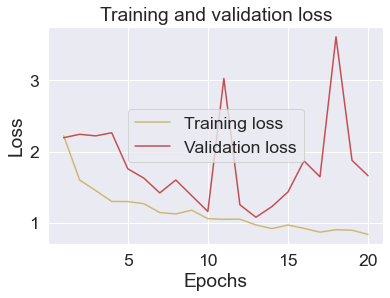

In [33]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

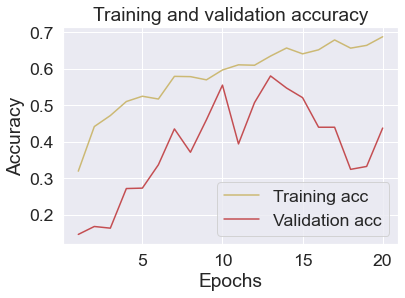

<AxesSubplot:>

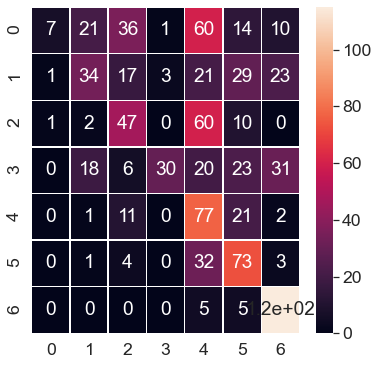

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

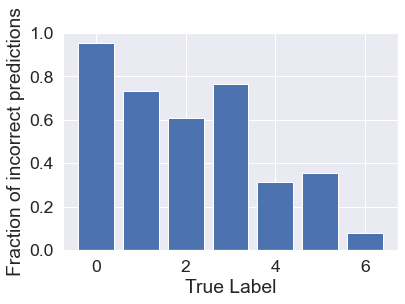

In [35]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')